In [1]:
import sympy as sp
import operator
from functools import partial, reduce
from lbmpy.chapman_enskog import *
from lbmpy.creationfunctions import createLatticeBoltzmannMethod
from pystencils.display_utils import toDot
from IPython.display import display

Diff = CeDiff
DiffOp = CeDiffOperator

sp.init_printing()

# Chapman Enskog analysis

Select parameters for the CE analysis here:

In [2]:
dim = 2
dimLabels = [sp.Rational(0,1), sp.Rational(1,1), sp.Rational(2,1)][:dim]
#dimLabels = ['0', '1', '2'][:dim]

method = createLatticeBoltzmannMethod(stencil="D2Q9", 
                                      equilibriumAccuracyOrder=2,
                                      compressible=True)

taylorOrder = 2

Definition of particle distribution function $f$ and collision operator $C$, and differential operators

In [3]:
# Velocity, Pdf, time ...
c = sp.Matrix([sp.Symbol(f"c_{label}") for label in dimLabels])
dt, t, f, C = sp.symbols("Delta_t t f C")

# Differential Operators
Dt = DiffOp(label=t)
Dx = sp.Matrix([DiffOp(label=l) for l in dimLabels])

### Taylor expansion of LBM equation

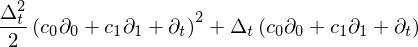

In [4]:
taylorOperator = sum(dt**k * (Dt + c.dot(Dx) )**k / sp.functions.factorial(k)
                     for k in range(1, taylorOrder+1))
taylorOperator

As right-hand-side we use the abstract collision operator $C$, which corresponds to (4.5)

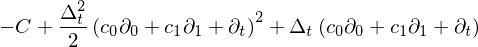

In [5]:
eq_4_5 = taylorOperator - C
eq_4_5

Following the same steps as in the book, getting rid of second derivative, and discarding $\Delta_t^3$ we get to (4.7)

In [6]:
operator = ((dt/2)* (Dt + c.dot(Dx))).expand()
applied_eq_4_5 = applyLinearity( applyDiffs(eq_4_5, f), [f, C])
opTimesEq_4_5 = applyLinearity( applyDiffs(operator, applied_eq_4_5), [f, C] ).expand()
opTimesEq_4_5 = normalizeDiffOrder(opTimesEq_4_5, [f,C])

eq_4_7 = (applied_eq_4_5 - opTimesEq_4_5).subs(dt**3, 0)
eq_4_7

     Δₜ⋅c₀⋅Diff(C, 0, -1)                          Δₜ⋅c₁⋅Diff(C, 1, -1)       
-C + ──────────────────── + Δₜ⋅c₀⋅Diff(f, 0, -1) + ──────────────────── + Δₜ⋅c
              2                                             2                 

                   Δₜ⋅Diff(C, t, -1)                    
₁⋅Diff(f, 1, -1) + ───────────────── + Δₜ⋅Diff(f, t, -1)
                           2                            

### Chapman Enskog Ansatz

In [7]:
# Expand Derivatives
eq_4_7_ce = eq_4_7
eq_4_7_ce = chapmanEnskogDerivativeExpansion(eq_4_7_ce, t, stopOrder=3)
for l in dimLabels:
    eq_4_7_ce = chapmanEnskogDerivativeExpansion(eq_4_7_ce, l, stopOrder=2)
    
# Expand distribution function
eps = sp.Symbol("epsilon")
eq_4_7_ce = eq_4_7_ce.expand()

fExpansionOrder = 3
expandedF = sum([eps**i * getExpandedName(f,i) for i in range(fExpansionOrder)])
fs = [getExpandedName(f,i) for i in range(fExpansionOrder)]
eq_4_7_ce = eq_4_7_ce.subs(f, expandedF)

Inserting SRT Collision operator

In [8]:
srtC = -dt / sp.Symbol("tau") * ( expandedF - getExpandedName(f,0))
srtC
eq_4_7_ce = eq_4_7_ce.subs(C, srtC).expand()

In [9]:
eq_4_7_ce = applyLinearity(eq_4_7_ce, fs).expand().collect(eps)

### Grouping orders in $\epsilon$
$ \mathcal{O}(\epsilon) $:

In [10]:
eq_4_9_a = (eq_4_7_ce.coeff(eps) / dt).expand()
eq_4_9_a

                                                  f__{(1)}                    
c₀⋅Diff(f^{(0)}, 0, 1) + c₁⋅Diff(f^{(0)}, 1, 1) + ──────── + Diff(f^{(0)}, t, 
                                                     τ                        

  
1)
  

$ \mathcal{O}(\epsilon^2) $:

In [11]:
eq_4_9_b = (eq_4_7_ce.coeff(eps**2) / dt).expand()
eq_4_9_b

  Δₜ⋅c₀⋅Diff(f^{(1)}, 0, 1)   Δₜ⋅c₁⋅Diff(f^{(1)}, 1, 1)   Δₜ⋅Diff(f^{(1)}, t, 
- ───────────────────────── - ───────────────────────── - ────────────────────
             2⋅τ                         2⋅τ                       2⋅τ        

1)                                                     f__{(2)}               
── + c₀⋅Diff(f^{(1)}, 0, 1) + c₁⋅Diff(f^{(1)}, 1, 1) + ──────── + Diff(f^{(0)}
                                                          τ                   

                             
, t, 2) + Diff(f^{(1)}, t, 1)
                             

### Computing moments

In [19]:
ceFs = [getExpandedName(f,i) for i in range(3)]
def tm(eq):
    result = takeMoments(eq, ceFs, list(c))
    result = insertMomentsFromMethod( result, method )
    result = insertMomentsSolvabilityCondition(result)
    result = applyLinearity(result, result.atoms(sp.Symbol))
    return result

$ \mathcal{O}(\epsilon) $ Moments:

In [28]:
eq_4_10_a = tm(eq_4_9_a)
eq_4_10_b = tm(eq_4_9_a * c[0])
eq_4_10_c = tm(eq_4_9_a * c[0] * c[1])
display(eq_4_10_a, eq_4_10_b, eq_4_10_c)

Diff(rho, t, 1) + Diff(rho*u_0, 0, 1) + Diff(rho*u_1, 1, 1)

Diff(rho, 0, 1)                                                               
─────────────── + Diff(rho*u_0, t, 1) + Diff(rho*u_0**2, 0, 1) + Diff(rho*u_0*
       3                                                                      

          
u_1, 1, 1)
          

\Pi   Diff(rho*u_0, 1, 1)   Diff(rho*u_1, 0, 1)                          
─── + ─────────────────── + ─────────────────── + Diff(rho*u_0*u_1, t, 1)
 τ             3                     3                                   

$ \mathcal{O}(\epsilon^2) $ Moments:

In [21]:
eq_4_12_a = tm(eq_4_9_b)
eq_4_12_b = tm(eq_4_9_b * c[0])
display(eq_4_12_a, eq_4_12_b)

Diff(rho, t, 2)

  Δₜ⋅Diff(\Pi, 0, 1)   Δₜ⋅Diff(\Pi, 1, 1)                                     
- ────────────────── - ────────────────── + Diff(\Pi, 0, 1) + Diff(\Pi, 1, 1) 
         2⋅τ                  2⋅τ                                             

                     
+ Diff(rho*u_0, t, 2)
                     

### Recombination of different orders

In [22]:
(eps * eq_4_10_a + eps**2 * eq_4_12_a).expand()

 2                                                                            
ε ⋅Diff(rho, t, 2) + ε⋅Diff(rho, t, 1) + ε⋅Diff(rho*u_0, 0, 1) + ε⋅Diff(rho*u_

        
1, 1, 1)

In [23]:
(eps * eq_4_10_b + eps**2 * eq_4_12_b).expand()

      2                       2                                               
  Δₜ⋅ε ⋅Diff(\Pi, 0, 1)   Δₜ⋅ε ⋅Diff(\Pi, 1, 1)    2                    2     
- ───────────────────── - ───────────────────── + ε ⋅Diff(\Pi, 0, 1) + ε ⋅Diff
           2⋅τ                     2⋅τ                                        

                                                                              
               2                       ε⋅Diff(rho, 0, 1)                      
(\Pi, 1, 1) + ε ⋅Diff(rho*u_0, t, 2) + ───────────────── + ε⋅Diff(rho*u_0, t, 
                                               3                              

                                                         
                                                         
1) + ε⋅Diff(rho*u_0**2, 0, 1) + ε⋅Diff(rho*u_0*u_1, 1, 1)
                                                         

### Moments $\Pi^{(1)}_{\alpha\beta}$

- results should have all time derivatives replaced by spatial derivatives
- input equations: (4.10 a-c)
    - for moment of second order, the input equation is the second moment of the $O(\epsilon)$  equation, which has 
      the relevant moment on the rhs
    - additionally the lower order moments of the same equation are used as well

In [36]:
momToSolveFor = CeMoment("\Pi", (1,1), 1)
momToSolveFor

In [45]:
secondOrderMomentEq = sp.solve( tm(eq_4_9_a * c[0] * c[1]), momToSolveFor)[0]
secondOrderMomentEq = expandDiffs(secondOrderMomentEq).expand()
secondOrderMomentEq

                                                   ρ⋅τ⋅Diff(u_0, 1, 1)   ρ⋅τ⋅D
-ρ⋅τ⋅u₀⋅Diff(u_1, t, 1) - ρ⋅τ⋅u₁⋅Diff(u_0, t, 1) - ─────────────────── - ─────
                                                            3                 

iff(u_1, 0, 1)                             τ⋅u₀⋅Diff(rho, 1, 1)   τ⋅u₁⋅Diff(rh
────────────── - τ⋅u₀⋅u₁⋅Diff(rho, t, 1) - ──────────────────── - ────────────
    3                                               3                      3  

o, 0, 1)
────────
        

Time derivatives have to be replaced with information from lower order moments